<a href="https://colab.research.google.com/github/hws2002/Deep_Learning_with_Keras/blob/main/Chapter9/Chapter9_4_interpreting_convNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 중간 활성화 시각화

8.2절에서 저장했던 모델을 로드해서 각 채널 내용을 독립적인 2D 이미지로 그려 보자

In [2]:
from tensorflow import keras
model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras"
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

In [3]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file( # 테스트 이미지를 내려받음
    fname = "cat.jpg",
    origin = 'https://img-datasets.s3.amazonaws.com/cat.jpg'
)
img_path

'/root/.keras/datasets/cat.jpg'

In [4]:
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(
      img_path, target_size = target_size
  )
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis = 0)
  return array

img_tensor = get_img_array(img_path, target_size = (180,180))

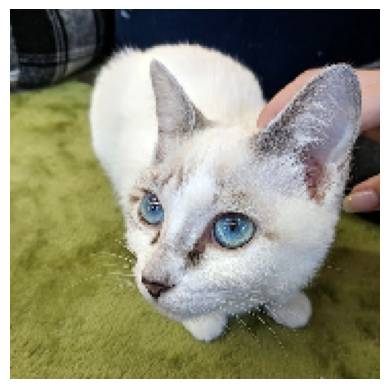

In [5]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

# 활성화 출력 모델
확인하고 싶은 특성 맵을 추출하기 위해 이미지 배치를 입력으로 받아 모든 합성곱과 풀링층의 활성화를  출력하는 케라스 모델을 만들어 보자

In [6]:
from keras import layers

layer_outputs = []
layer_names = []

for layer in model.layers:
  if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)

activation_model = keras.Model(inputs = model.input, outputs = layer_outputs)

이 모델은 하나의 입력과 층의 활성화마다하나씩 총 9개의 출력을 가짐

In [7]:
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


예를 들어 고양이 이미지에 대한 첫 번쨰 합성곱 층의 활성화 값은 다음과 같음

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


이 활성화는 32개의 채널을 가진 178 x 178 크기의 특성 맵임.  
원본 모델의 첫 번째 층 활성화 중에서 다섯 번째 채널을 그려 보자

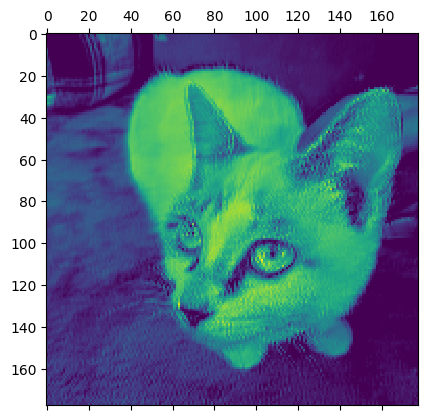

In [9]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap = "viridis")
plt.show()

이제 네트워크의 모든 활성화를 시각화 해보자  
각 층의 활성화에 있는 모든 채널을 그리기 위해 하나의 큰 이미지 그리드에 추출한 결과를 나란히 쌓을 것임

<ipython-input-16-cbab8d2b6b31>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (scale * display_grid.shape[1],


<Figure size 1608.43x200.562 with 0 Axes>

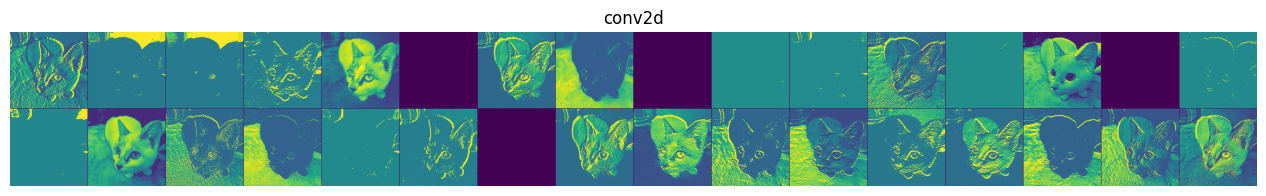

<Figure size 1616.85x201.124 with 0 Axes>

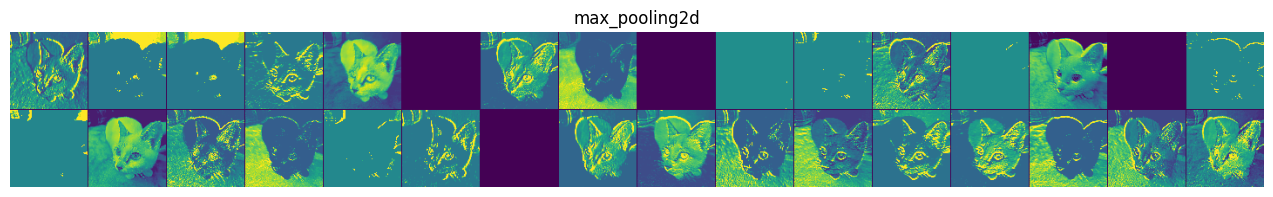

<Figure size 1617.24x403.448 with 0 Axes>

<Figure size 1617.24x403.448 with 0 Axes>

<Figure size 1617.24x403.448 with 0 Axes>

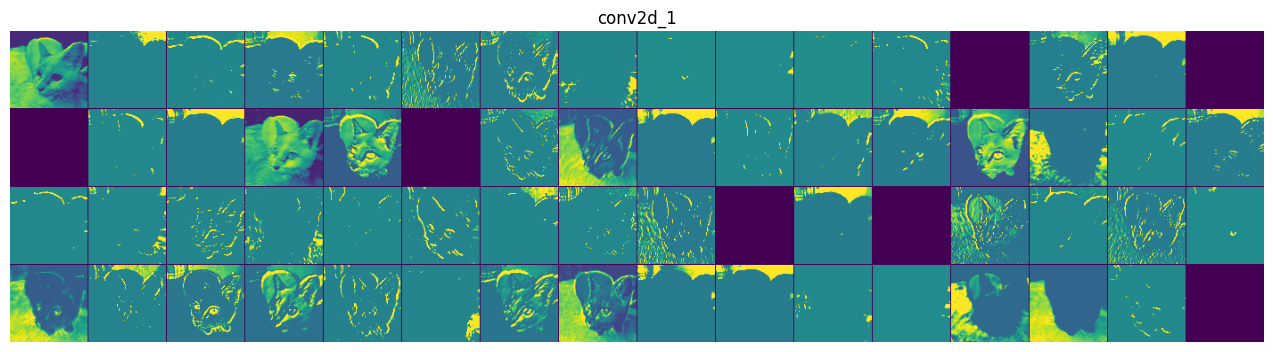

<Figure size 1634.88x406.977 with 0 Axes>

<Figure size 1634.88x406.977 with 0 Axes>

<Figure size 1634.88x406.977 with 0 Axes>

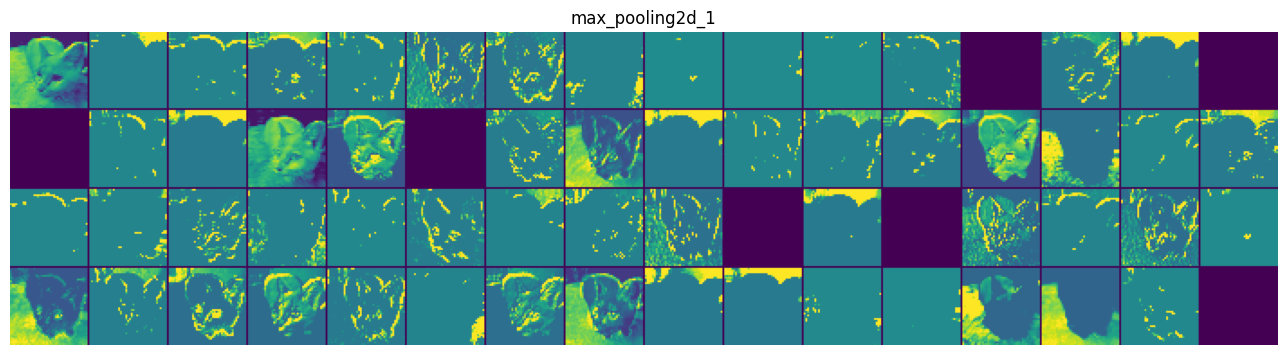

<Figure size 1636.59x817.073 with 0 Axes>

<Figure size 1636.59x817.073 with 0 Axes>

<Figure size 1636.59x817.073 with 0 Axes>

<Figure size 1636.59x817.073 with 0 Axes>

<Figure size 1636.59x817.073 with 0 Axes>

<Figure size 1636.59x817.073 with 0 Axes>

<Figure size 1636.59x817.073 with 0 Axes>

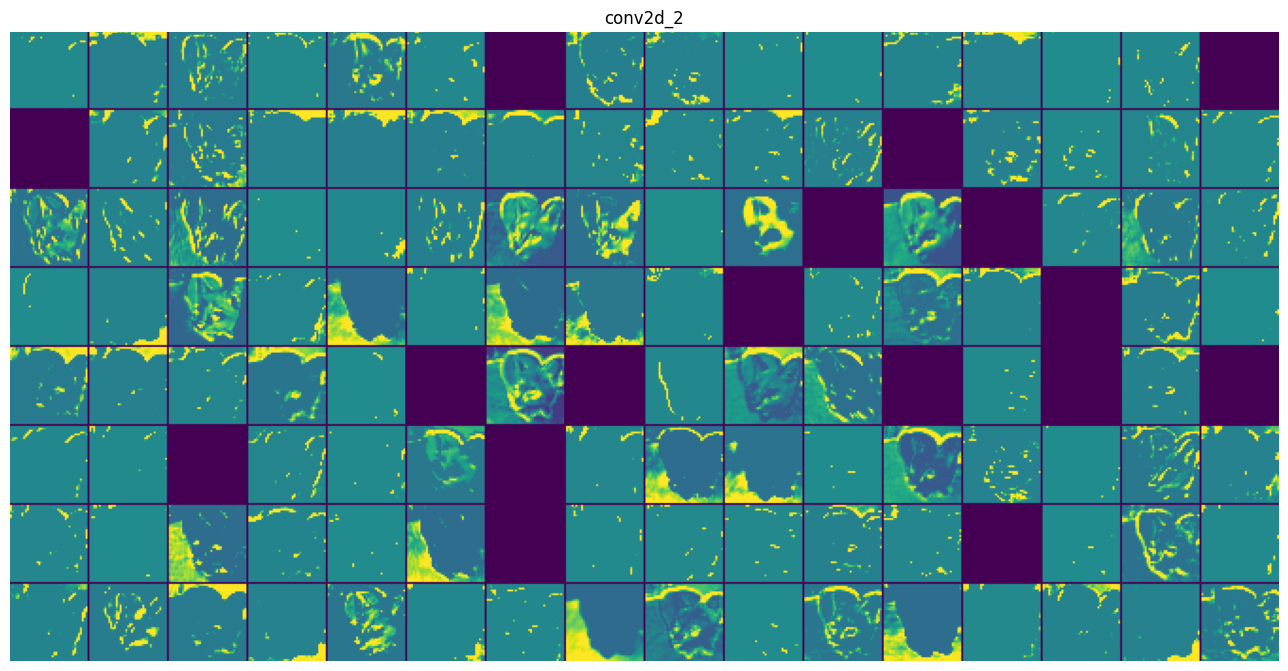

<Figure size 1675x835 with 0 Axes>

<Figure size 1675x835 with 0 Axes>

<Figure size 1675x835 with 0 Axes>

<Figure size 1675x835 with 0 Axes>

<Figure size 1675x835 with 0 Axes>

<Figure size 1675x835 with 0 Axes>

<Figure size 1675x835 with 0 Axes>

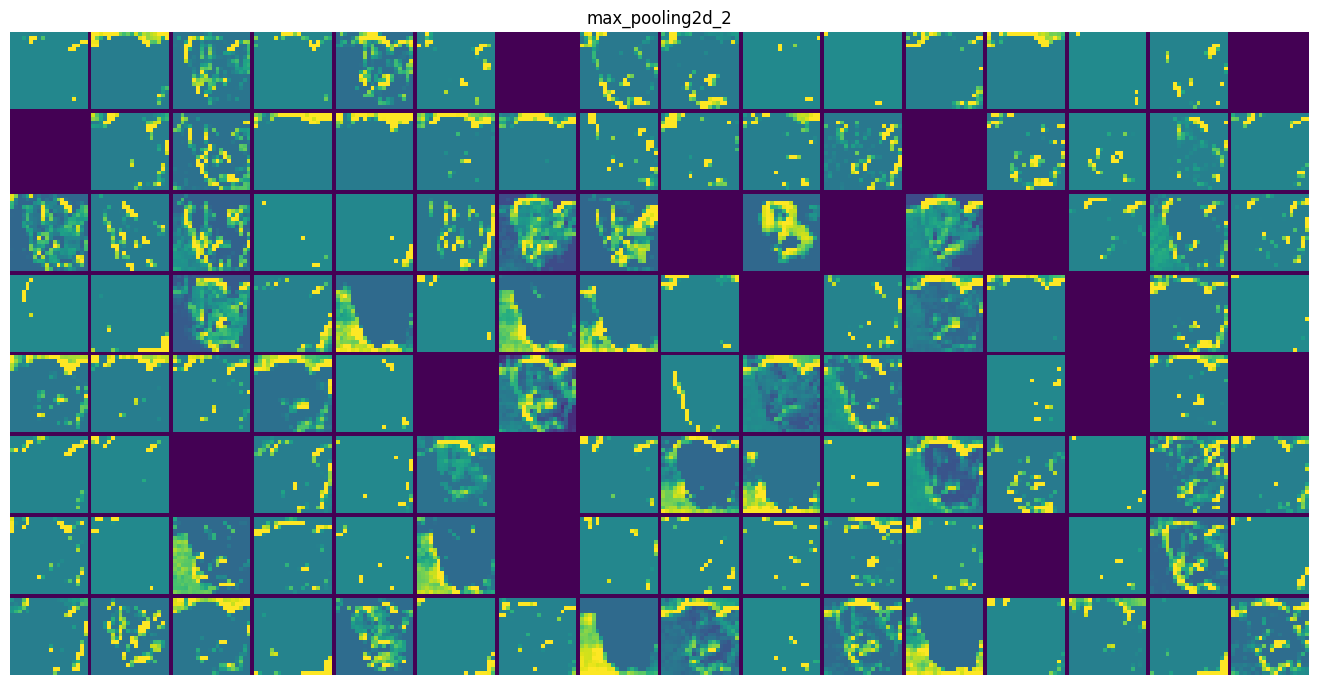

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

<Figure size 1683.33x1683.33 with 0 Axes>

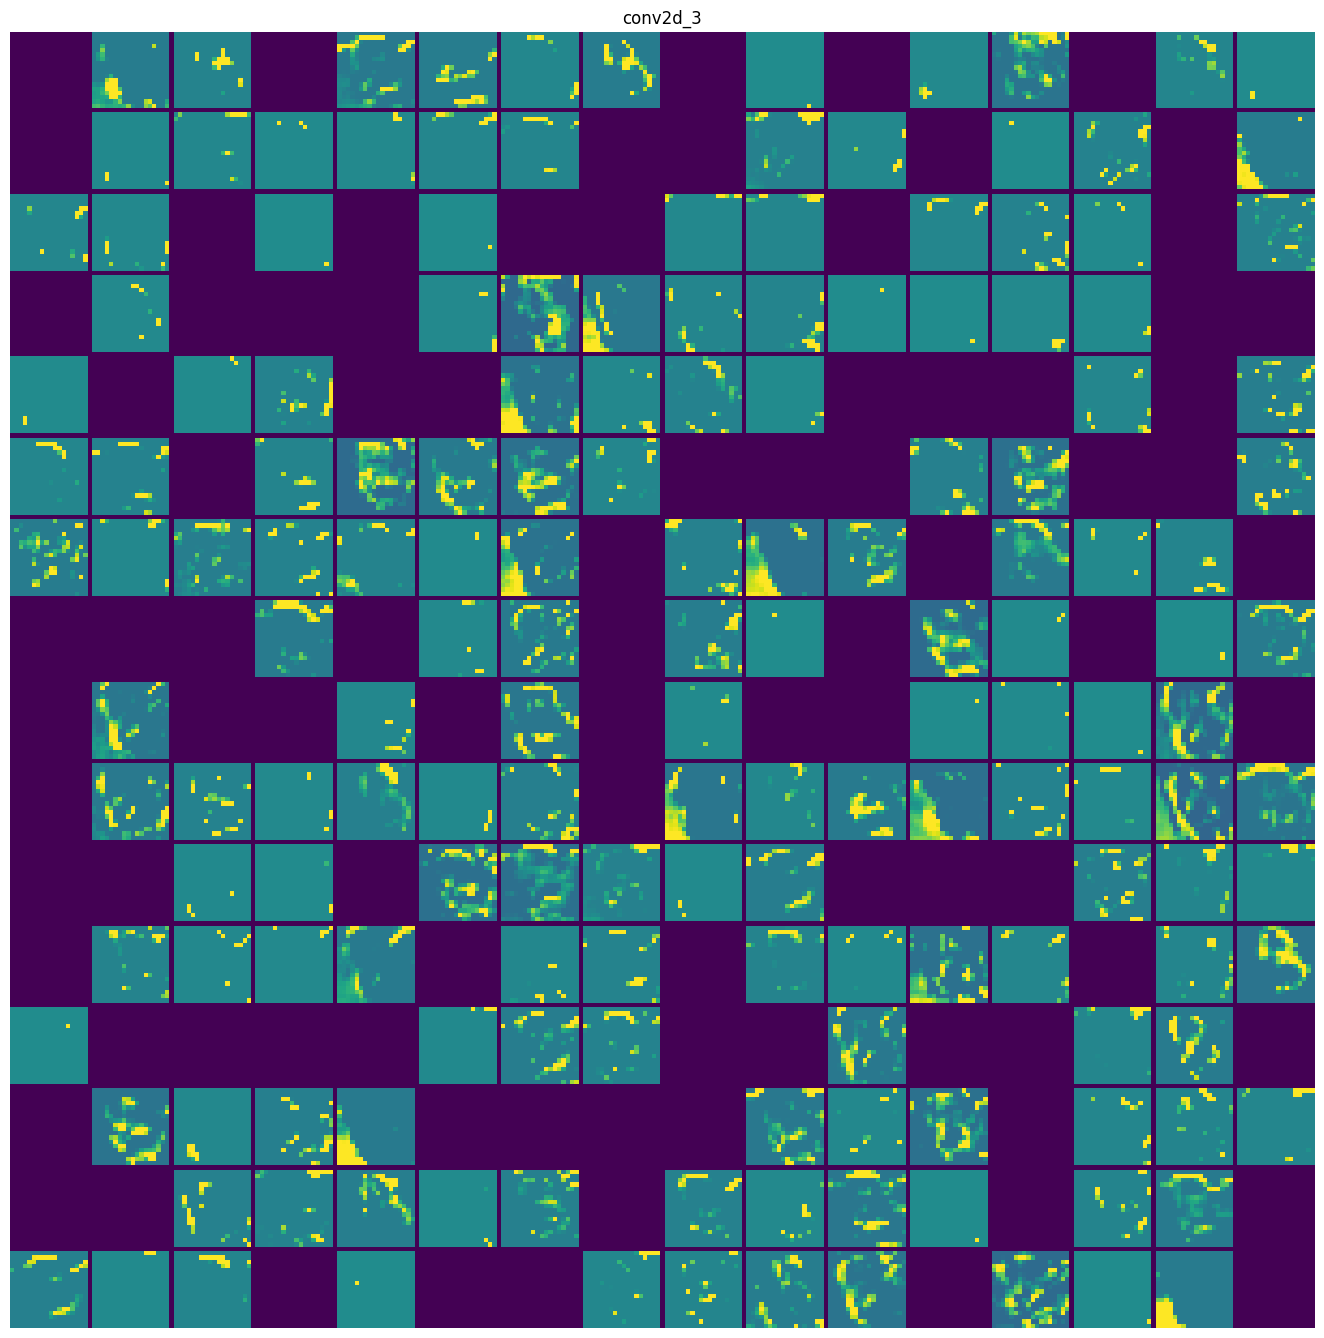

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

<Figure size 1766.67x1766.67 with 0 Axes>

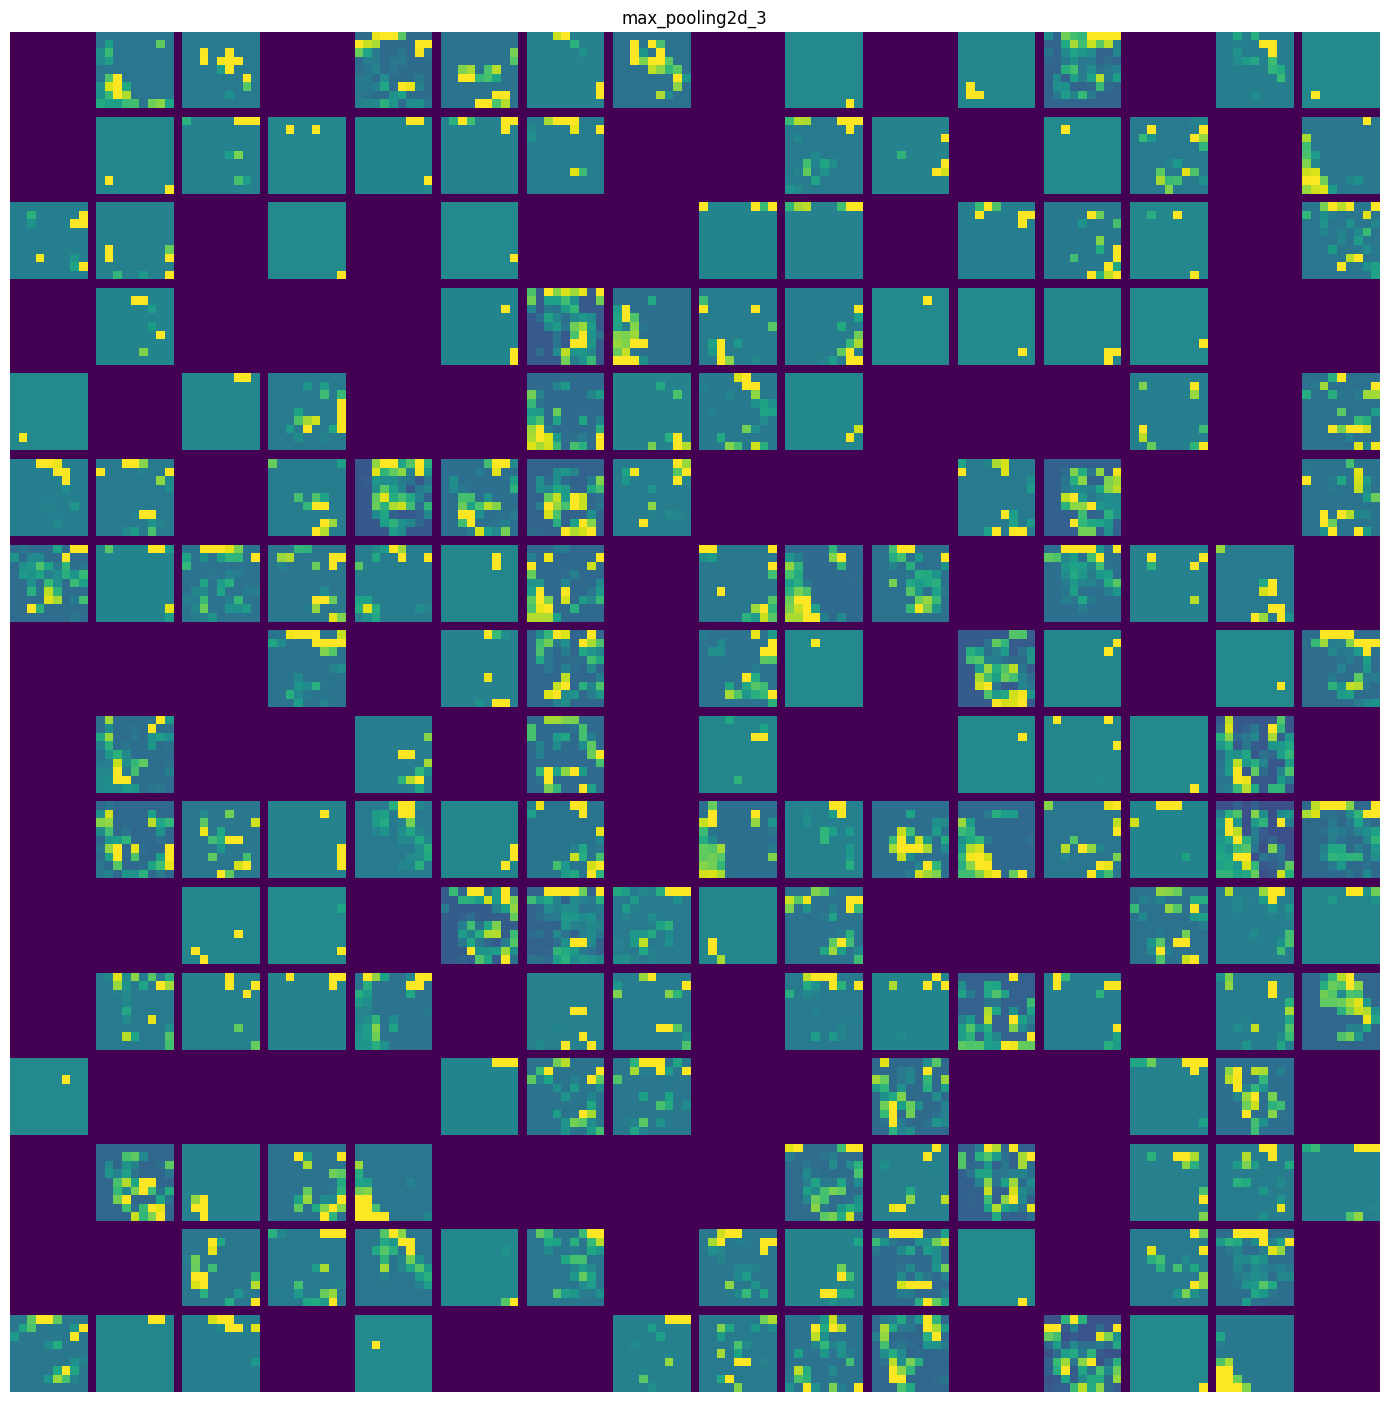

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

<Figure size 1814.29x1814.29 with 0 Axes>

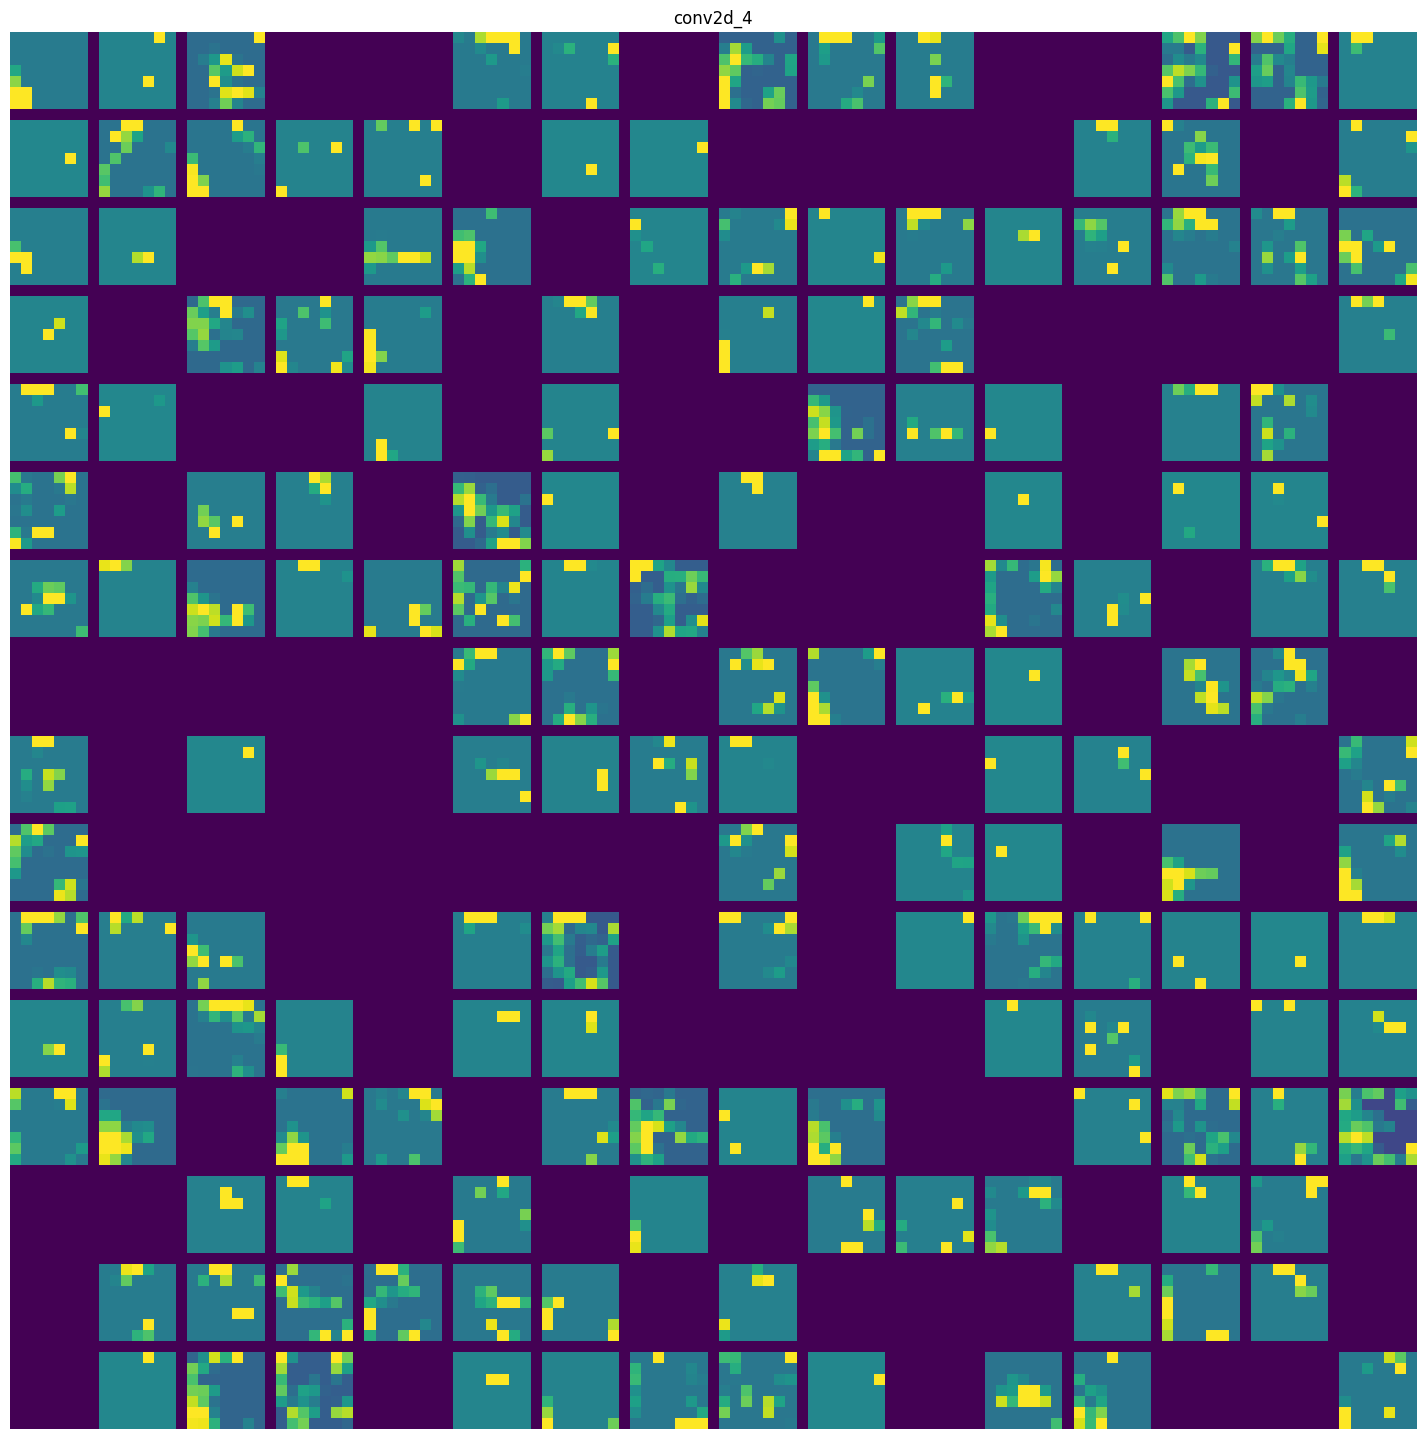

In [16]:
# row랑 col이랑 crossed됌
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1] # 층 활성화 크기는 (1, size, size, n_features)임
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros(( (size+1) * n_cols - 1,
                           images_per_row * (size + 1) - 1)) # 활성화에 있는 모든 채널을 출력하기 위해 빈 그리드를 준비함
  # size + 1 accounts for a small gap between images
  # -1 is to avoid extra padding

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_index = col * images_per_row + row
      channel_image = layer_activation[0, :, :, channel_index].copy() # 하나의 채널 이미지

      if channel_image.sum() != 0: # 채널 값을 [0, 255] 범위로 정규화함. 모두 0인 채널은 그대로 둠
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128

      channel_image = np.clip(channel_image, 0, 255).astype("uint8")
      display_grid[
          col * (size + 1) : (col + 1) * size + col,
          row * (size + 1) : (row + 1) * size + row
      ] = channel_image

    scale = 1. /size
    plt.figure(figsize = (scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))

  plt.title(layer_name)
  plt.grid(False)
  plt.axis("off")
  plt.imshow(display_grid, aspect = "auto", cmap = "viridis")

주목할 만한 것들
1. 첫 번쨰 층은 여러 종류의 에지 감지기를 모아 놓은 것 같음. 이 단계의 활성화에는 초기 이미지에 있는 거의 모든 정보가 유지됨

2. 층이 깊어질술고 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워짐. '고양이 귀'와 '고양이 눈'처럼 고수준 개념을 인코딩하기 시작. 깊은 층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가함.

3. 비어 있는 활성화가 층이 깊어짐에 따라 늘어남. 이는 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미함.

# 컨브넷 필터 시각화

컨브넷이 학습한 필터를 조사하는 또 다른 간편한 방법은 각 필터가 반응하는 시각적 패턴을 그려 보는 것임. 빈 입력 이미지에서 시작해서 특정 필터의 응답을 최대화하기 위해 컨브넷 입력 이미지에 경사 상승법을 적용해서, 결과적으로 입력 이미지는 선택된 필터가 최대로 응답하는 이미지가 될 것임.

ImageNet에서 사전 훈련된 Xception 모델의 필터를 사용해 보자.

먼저 특정 합성곱 층의 한 필터 값을 최대화하는 손실 함수를 정의하고, 이 활성화 값을 최대화하기 위해 입력 이미지를 변경하도록 확률적 경사 상승법을 사용하자. (GradientTape 객체를 사용할 것임)

In [19]:
model = keras.applications.xception.Xception(
    weights = "imagenet",
    include_top = False
)

In [101]:
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

먼저 깊이 순서대로 이름을 출력해보자

In [106]:
layer_names = []
for layer in model.layers:
  if isinstance(layer,(keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)
    layer_names.append(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_4
block3_sepconv1
block3_sepconv2
conv2d_5
block4_sepconv1
block4_sepconv2
conv2d_6
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_7
block14_sepconv1
block14_sepconv2


SeparableConv2D층의 이름은 모두 block6_sepconv1, block7_sepconv2와 같은 식임.  
Xception은 여러 개의 합성곱 층을 담은 블록으로 구성되어 있음.

### 특성 추출 모델 만들기
함수형 API를 사용한 모델이므로, 한층의 output을 추출하는 모델을 만들어보자

In [183]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name = layer_name)
feature_extractor = keras.Model(inputs = model.input, outputs = layer.output)

이 모델을 사용하려면 어떤 입력 데이터에서 모델을 호출하면 됌

In [184]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

특성 추출 모델을 사용해서 입력 이미지가 층의 필터를 얼마나 활성화하는지 정량화된 스칼라 값을 반환하는 함수를 정의한다.

In [185]:
import tensorflow as tf

def compute_losses(image, filter_index):
  activation = feature_extractor(image)
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  # 손실에 경계 픽셀을 제외시켜, 경게에 나타나는 부수 효과를 제외시킴. 테두리를 따라 두 픽셀을 제외시킴
  return tf.reduce_mean(filter_activation) # 이 필터에 대한 활성화 값의 평균을 반환함

이제 GradientTape를 사용해서 경사 상승법 단계를 구성해보자

In [187]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image) # 이미지 텐서는 텐서플로 변수가 아니기 때문에 명시적으로 지정함
    # 그레이디언트 테이프는 텐서플로 변수만 자동으로 검사함
    loss = compute_losses(image, filter_index)
  grads = tape.gradient(loss, image) # 이미지에 대한 손실의 그레이디언트를 계산
  grads = tf.math.l2_normalize(grads) # 그레이디언트 정규화 트릭
  image += learning_rate * grads
  return image, loss

이제 층 이름과 필터 인덱스를 입력으로 받고, 지정된 필터의 활성화를 최대화하는 패턴을 나타내는 텐서를 반환하는 파이썬 함수를 만들어 보자

In [175]:
img_width = 200
img_height = 200
def generate_filter_pattern(filter_index, verbose = False):
  iterations = 30
  learning_rate = 10.
  image = tf.random.uniform(
      minval = 0.4,
      maxval = 0.6,
      shape = (1, img_width, img_height, 3))
  for i in range(iterations):
    image, loss = gradient_ascent_step(image, filter_index, learning_rate)
    if verbose and i % 5 == 0:
      print(f"{i}번째 iteration 손실 : {loss:.2f}")
  return image[0].numpy()

maximizing_filter_pattern_image = generate_filter_pattern(0)

이 텐서 값은 [0,255] 사이의 정수가 아니므로, 출력 가능한 이미지로 변경하기 위해 후처리해준 후 시각화해보자

In [176]:
def deprocess_image(image):
  image -= image.mean()
  image /= image.std()
  image *= 64
  image += 128
  image = np.clip(image, 0, 255).astype("uint8")
  image = image[25:-25, 25:-25, :]
  return image

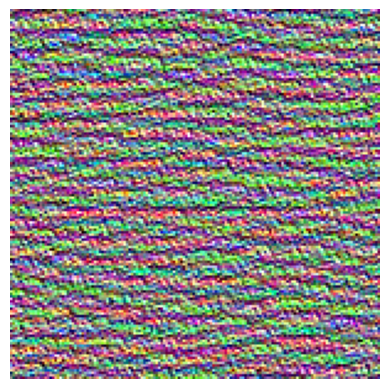

In [188]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(2)))
plt.show()

block3_sepconv1층에 있는 세 번째 필터는 약간 물이나 털 같은 수평 패턴에 반응하는 것 같음.

이제 층의 모든 필터를 시각화하거나 모델에 있는 모든 층의 필터를 시각화해보자

In [ ]:
all_images = []
for filter_index in range(64):
  print(f"{filter_index}번 필터 처리중")
  image = deprocess_image(
      generate_filter_pattern(filter_index)
  )
  all_images.append(image)
  plt.imshow(image)

margin = 5 # 필터 시각화를 출력할 빈 이미지를 준비한다
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n-1) * margin
height = n * cropped_height + (n-1) * margin
stitched_filters = np.zeros((width,height,3))

# stitched_filters[0: cropped_height, 0 : cropped_width,:] = image
for i in range(n):
  for j in range(n):
    image = all_images[i*n+j]
    stitched_filters[
        i * (cropped_height + margin) : i * (cropped_height + margin) + cropped_height,
        j * (cropped_width + margin) : j * (cropped_width + margin) + cropped_width,
        :
    ] = image

plt.axis("off")
plt.title(f"filters_for_layer_{layer_name}")
plt.matshow(stitched_filters)
keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

In [ ]:
for layer_name in layer_names:
  layer = model.get_layer(name = layer_name)
  print(f"{layer_name} 레이어 처리중")
  feature_extractor = keras.Model(inputs = model.input, outputs = layer.output)
  activation = feature_extractor(
      keras.applications.xception.preprocess_input(img_tensor)
  )

  def compute_losses(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    # 손실에 경계 픽셀을 제외시켜, 경게에 나타나는 부수 효과를 제외시킴. 테두리를 따라 두 픽셀을 제외시킴
    return tf.reduce_mean(filter_activation) # 이 필터에 대한 활성화 값의 평균을 반환함
  @tf.function
  def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
      tape.watch(image) # 이미지 텐서는 텐서플로 변수가 아니기 때문에 명시적으로 지정함
      # 그레이디언트 테이프는 텐서플로 변수만 자동으로 검사함
      loss = compute_losses(image, filter_index)
    grads = tape.gradient(loss, image) # 이미지에 대한 손실의 그레이디언트를 계산
    grads = tf.math.l2_normalize(grads) # 그레이디언트 정규화 트릭
    image += learning_rate * grads
    return image, loss

  all_images = []
  num_filters = layer.output.shape[-1]
  for filter_index in range(min(64, num_filters)):
    print(f"{filter_index}번 필터 처리중")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)
    plt.imshow(image)

  margin = 5 # 필터 시각화를 출력할 빈 이미지를 준비한다
  n = min(8, int(np.sqrt(num_filters)))
  cropped_width = img_width - 25 * 2
  cropped_height = img_height - 25 * 2
  width = n * cropped_width + (n-1) * margin
  height = n * cropped_height + (n-1) * margin
  stitched_filters = np.zeros((width,height,3))

  for i in range(n):
    for j in range(n):
      image = all_images[i*n+j]
      stitched_filters[
          i * (cropped_height + margin) : i * (cropped_height + margin) + cropped_height,
          j * (cropped_width + margin) : j * (cropped_width + margin) + cropped_width,
          :
      ] = image

  # plt.axis("off")
  # plt.title(f"filters_for_layer_{layer_name}")
  # plt.matshow(stitched_filters)
  keras.utils.save_img(
      f"filters_for_layer_{layer_name}.png", stitched_filters)

# 클래스 활성화 맵 Class Activatoin MAP, CAM
초원을 걷는 어미와 새끼 아프리카 코끼리의 이미지를 적용해 보자.  


In [124]:
img_path = keras.utils.get_file(
    fname = "elephant.jpg",
    origin = "https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

def get_img_array(img_path, target_size):
  img = keras.utils.load_img(
      img_path, target_size = target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis = 0)
  array = keras.applications.xception.preprocess_input(array)
  return array

img_array = get_img_array(img_path, target_size = (299,299))

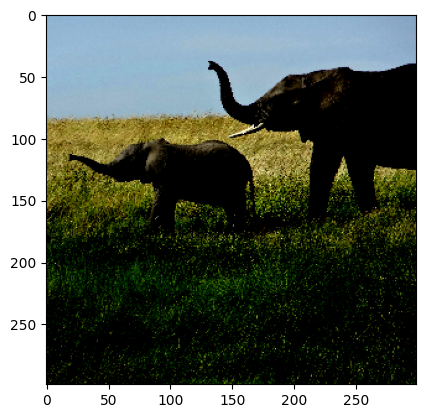

In [129]:
plt.imshow(img_array[0])
plt.show()

이제 이 이미지에서 사전 훈련된 네트워크를 실행하고 예측 벡터를 이해하기 쉽게 디코딩해보자

In [136]:
model_include = keras.applications.xception.Xception(
    weights = "imagenet",
    include_top = True
)

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [137]:
model_include.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [144]:
preds = model_include.predict(img_array)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


(1, 1000)

In [139]:
print(keras.applications.xception.decode_predictions(preds, top = 3)[0])

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[('n02504458', 'African_elephant', 0.86993945), ('n01871265', 'tusker', 0.076956354), ('n02504013', 'Indian_elephant', 0.023541784)]


이 네트워크는 이미지가 아프리카 코끼리를 담고 있다고 인식했음

In [140]:
np.argmax(preds[0])

386

예측 벡터에서 최대로 활성화된 항목은 '아프리카 코끼리'클래스에 대한 것으로 386번 인덱스임

## Grad-CAM 처리
이미지에서 가장 아프리카 코끼리와 같은 부위를 시각화하기 위해 Grad-CAM 처리 과정을 구현해보자.  

먼저 입력 이미지를 마지막 합성곱 층의 활성화에 매핑하는 모델을 만들자

In [147]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

last_conv_layer = model_include.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(inputs = model_include.inputs, outputs = last_conv_layer.output)

그 다음 마지막 합성곱 층의 활성화를 최종 클래스 예측에 매핑하는 모델을 만든다

In [150]:
classifier_input = keras.Input(shape = last_conv_layer.output.shape[1:]) # exclude batch size
x = classifier_input
for layer_name in classifier_layer_names:
  x = model_include.get_layer(layer_name)(x)

classifier_model = keras.Model(classifier_input, x)

그 다음 마지막 합성곱 층의 활성화에 대한 최상위 예측 클래스의 그레이디언트를 계산한다

In [151]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array) # 마지막 합성곱 층의 활성화를 계산하고,
  tape.watch(last_conv_layer_output) # 그레이디언트 테이프로 감시한다
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient( top_class_channel, last_conv_layer_output)

In [153]:
pooled_grads = tf.reduce_mean(grads , axis = (0,1,2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:,:,i] *= pooled_grads[i]

heatmap = np.mean(last_conv_layer_output, axis = -1)

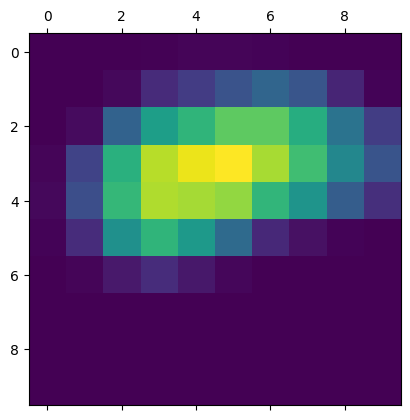

In [154]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

이 히트맵에 원본 그림을 겹친 이미지를 만들어 보자

In [156]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap) # 히트맵을 0~255 범위로 조정

jet = cm.get_cmap("jet") # jet 컬러맵을 사용해서 히트맵의 색을 바꿈
jet_colors = jet(np.arange(256))[:,:3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

<ipython-input-156-bcd82b3a7448>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet") # jet 컬러맵을 사용해서 히트맵의 색을 바꿈


이 시각화 기법은 2개의 중요한 질문에 대한 답을 줌
1. 왜 네트워크가 이 이미지에 아프리카 코끼리가 있다고 생각하는가?
2. 아프리카 코끼리가 사진 어디에 있는가?
